# Test daily reward loss
Test the new model to check if it is working correctly.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os 
#os.environ['MPLCONFIGDIR'] = "$HOME"
#os.envir
# on["WANDB_DIR"] = os.path.join(os.path.dirname(__file__), "..", "wandb")
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
# sys append 
sys.path.append("..")
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader
from models.earlyrnn import EarlyRNN
from models.daily_earlyrnn import DailyEarlyRNN
import torch
from tqdm import tqdm
from utils.losses.early_reward_loss import EarlyRewardLoss
from utils.losses.stopping_time_proximity_loss import StoppingTimeProximityLoss, sample_three_uniform_numbers
from utils.losses.daily_reward_loss import DailyRewardLoss
from utils.losses.loss_helpers import log_class_prob_at_t_plus_zt
from utils.losses.classification_loss import ClassificationLoss
from utils.losses.daily_reward_lin_regr_loss import DailyRewardLinRegrLoss
import sklearn.metrics
import pandas as pd
import wandb
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times
from utils.doy import get_doys_dict_test, get_doy_stop, create_sorted_doys_dict_test, get_approximated_doys_dict
from utils.helpers_training import parse_args_sweep, train_epoch
from utils.helpers_testing import test_epoch
from utils.metrics import harmonic_mean_score
from models.model_helpers import count_parameters, get_t_stop_from_daily_timestamps
import matplotlib.pyplot as plt


## Test the loss

In [3]:
# config 
class Config():
    def __init__(self):
        self.alpha = 0.9
        self.backbonemodel = "LSTM"
        self.batchsize = 256
        self.corrected = True
        self.dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
        self.dataset = "breizhcrops"
        self.device = "cuda"
        self.epochs = 100
        self.epsilon = 10
        self.extra_padding_list = [0]
        self.hidden_dims = 64
        self.learning_rate = 0.001
        self.loss_weight = "balanced"
        self.patience = 30
        self.resume = False
        self.sequencelength = 365
        self.validation_set = "valid"
        self.weight_decay = 0
        self.daily_timestamps = True
        self.original_time_serie_lengths = [102]
        self.loss = "daily_reward_lin_regr"
        self.day_head_init_bias = 5
        self.decision_head = "day"
        self.start_decision_head_training = 0
        self.alpha_decay = [.9, 0.8]
        self.percentage_earliness_reward = 0.9
        self.mu = 150.
        
config = Config()

In [4]:
dataroot = os.path.join(config.dataroot,"breizhcrops")
input_dim = 13
test_ds = BreizhCrops(root=dataroot,partition=config.validation_set, sequencelength=config.sequencelength, corrected=config.corrected, daily_timestamps=config.daily_timestamps, original_time_serie_lengths=config.original_time_serie_lengths)
train_ds = BreizhCrops(root=dataroot,partition="train", sequencelength=config.sequencelength, corrected=config.corrected, daily_timestamps=config.daily_timestamps, original_time_serie_lengths=config.original_time_serie_lengths)
nclasses = train_ds.nclasses
class_names = train_ds.labels_names
traindataloader = DataLoader(train_ds,batch_size=config.batchsize)
testdataloader = DataLoader(test_ds, batch_size=config.batchsize)

2559635960 2559635960


loading data into RAM: 100%|██████████| 67523/67523 [00:27<00:00, 2413.29it/s]


2253658856 2253658856


loading data into RAM: 100%|██████████| 85310/85310 [00:35<00:00, 2394.77it/s]


cost function: 

model: 

In [5]:
model = DailyEarlyRNN(config.backbonemodel, nclasses=nclasses, input_dim=input_dim, sequencelength=config.sequencelength, hidden_dims=config.hidden_dims).to(config.device)


optimizer

In [6]:
# exclude decision head linear bias from weight decay
decay, no_decay = list(), list()
for name, param in model.named_parameters():
    if name == "stopping_decision_head.projection.0.bias":
        no_decay.append(param)
    else:
        decay.append(param)

optimizer = torch.optim.AdamW([{'params': no_decay, 'weight_decay': 0, "lr": config.learning_rate}, {'params': decay}],
                                lr=config.learning_rate, weight_decay=config.weight_decay)



loss: 

In [7]:
import torch
from torch import nn
from utils.losses.loss_helpers import probability_correct_class, log_class_prob_at_t_plus_zt

MU_DEFAULT = 150.

class DailyRewardLinRegrLoss(nn.Module):
    def __init__(self, alpha:float=1., weight=None, alpha_decay: list=None, epochs: int=100, start_decision_head_training: int=0, **kwargs):
        """_summary_

        Args:
            alpha (float, optional): _description_. Defaults to 0.5.
            weight (list, optional): weight for each class, shape: (nclasses). Defaults to None.
            alpha_decay (list, optional): contains [alpha_decay_max, alpha_decay_min]. Through the epochs, starts at alpha_decay_max
                        and get closer to alpha_decay_min. Defaults to None.
            epochs (int, optional): number of epochs. Defaults to 100.
            start_decision_head_training (int, optional): epoch to start training the decision head. Defaults to 0.
        """
        super(DailyRewardLinRegrLoss, self).__init__()

        self.weight = weight
        self.negative_log_likelihood = nn.NLLLoss(reduction="none", weight=self.weight)
        self.alpha = alpha
        
        if alpha_decay is not None:
            self.alpha_decay_max = alpha_decay[0]
            self.alpha_decay_min = alpha_decay[1]
            self.epochs = epochs
        
        self.start_decision_head_training = start_decision_head_training
        # mus is a tensor of length nclasses, containing the mu for each class
        self.mus = kwargs.get("mus", torch.ones(len(weight))*MU_DEFAULT).to(weight.device)
        self.percentage_earliness_reward = torch.tensor(kwargs.get("percentage_earliness_reward", 0.5), device=weight.device)

    def forward(self, log_class_probabilities, timestamps_left, y_true, return_stats=False, **kwargs):
        N, T, C = log_class_probabilities.shape
        epoch = kwargs.get("epoch", 0)

        # equation 4, right term
        t = torch.ones(N, T, device=log_class_probabilities.device) * \
                torch.arange(T).type(torch.FloatTensor).to(log_class_probabilities.device)
        log_class_probabilities_at_t_plus_zt = log_class_prob_at_t_plus_zt(log_class_probabilities, timestamps_left)

        # compute alpha
        if hasattr(self, "alpha_decay_max"):
            if epoch >= self.start_decision_head_training:
                # alpha goes from alpha_decay_max to alpha_decay_min linearly
                self.alpha = self.alpha_decay_min + (self.alpha_decay_max - self.alpha_decay_min) * \
                    (1 - (epoch-self.start_decision_head_training)/(self.epochs-self.start_decision_head_training))
                            
        # earliness reward and linear regression loss
        if epoch>=self.start_decision_head_training and self.alpha<1.-1e-8:
            earliness_reward = probability_correct_class(log_class_probabilities_at_t_plus_zt, y_true, weight=self.weight) * (1-t/T) * (1-timestamps_left.float()/T)
            earliness_reward = earliness_reward.sum(1).mean(0)
            
            lin_regr_zt_loss = lin_regr_zt(t, T, self.mus, timestamps_left.float(), y_true) # (N, T)
            lin_regr_zt_loss = lin_regr_zt_loss.sum(1).mean(0) # sum over time, mean over batch
        else:
            # if the decision head is not trained, the earliness reward is zero
            earliness_reward = torch.tensor(0.0, device=log_class_probabilities.device) 
            lin_regr_zt_loss = torch.tensor(0.0, device=log_class_probabilities.device)
            
        # classification loss
        cross_entropy = self.negative_log_likelihood(log_class_probabilities.view(N*T,C), y_true.view(N*T)).view(N,T)
        classification_loss = cross_entropy.sum(1).mean(0)

        # final loss
        alpha_1 = (1.-self.alpha)*self.percentage_earliness_reward
        self.alphas = torch.tensor([self.alpha, alpha_1, 1.-self.alpha-alpha_1], device=log_class_probabilities.device)
        loss = self.alphas[0]*classification_loss - self.alphas[1]*earliness_reward + self.alphas[2]*lin_regr_zt_loss

        if return_stats:
            stats = dict(
                classification_loss=classification_loss.cpu().detach().numpy(),
                earliness_reward=earliness_reward.cpu().detach().numpy(),
                timestamps_left=timestamps_left.cpu().detach().numpy(),
                lin_regr_zt_loss=lin_regr_zt_loss.cpu().detach().numpy(),
            )
            return loss, stats
        else:
            return loss
        
    def update_mus(self, mus):
        self.mus = mus.clone().detach().to(device=self.mus.device)
        

def lin_regr_zt(t, T, mus, z_t, y_true):
    """ 
    t: tensor of shape (N, T)
    T: float 
    mus: tensor of shape (C)
    z_t: tensor of shape (N, T)
    y_true: tensor of shape (N, T)
    
    OUTPUT: 
    loss: tensor of shape (N, T), 
    """
    # lin_term is either mus[y_true]-t-z_t for t<=mus[y_true], or z_t otherwise
    lin_term = torch.where(t<=mus[y_true], mus[y_true]-t-z_t, z_t)
    return (lin_term/T)**2


In [8]:
if config.loss_weight == "balanced":
    class_weights = train_ds.get_class_weights().to(config.device)
else: 
    class_weights = None

if config.loss == "early_reward":
    criterion = EarlyRewardLoss(alpha=config.alpha, epsilon=config.epsilon, weight=class_weights)
elif config.loss == "stopping_time_proximity":
    criterion = StoppingTimeProximityLoss(alphas=config.alphas, weight=class_weights)
elif config.loss == "daily_reward_loss":
    criterion = DailyRewardLoss(alpha=config.alpha, weight=class_weights)
elif config.loss == "classification_loss":
    criterion = ClassificationLoss(weight=class_weights)
elif config.loss == "daily_reward_lin_regr":
    mu = config.mu if hasattr(config, "mu") else MU_DEFAULT
    mus = torch.ones(nclasses, device=config.device)*mu
    dict_criterion = {"mus": mus,
                      "percentage_earliness_reward": config.percentage_earliness_reward if hasattr(config, "percentage_earliness_reward") else 0.9,}
    criterion = DailyRewardLinRegrLoss(alpha=config.alpha, weight=class_weights, alpha_decay=config.alpha_decay, epochs=config.epochs, \
        start_decision_head_training=config.start_decision_head_training if hasattr(config, "start_decision_head_training") else 0, \
        **dict_criterion)
else: 
    raise ValueError("Loss not implemented")

In [9]:
print(criterion.mus)
print(criterion.percentage_earliness_reward)
print(criterion.alpha)

tensor([150., 150., 150., 150., 150., 150., 150.], device='cuda:0')
tensor(0.9000, device='cuda:0')
0.9


test lin_regr_zt

In [21]:
# Dummy Variables
N = 5   # Number of samples
C = 7   # Number of categories
T_dim = 365  # Temporal dimension, can adjust as needed

# Create dummy tensors
t = torch.randn(N, T_dim)  # Random tensor for 't'
mus = torch.rand(C)  # Random values for 'mus', ensure they are positive
z_t = torch.randn(N, T_dim)  # Random tensor for 'z_t'
y_true = torch.randint(0, C, (N, T_dim))  # Random indices from 0 to C-1

# Calculate the output
output = lin_regr_zt(t, T_dim, mus, z_t, y_true)
print("Output Loss Tensor:", output)

Output Loss Tensor: tensor([[1.8238e-05, 9.1451e-10, 1.8677e-05,  ..., 7.1826e-06, 2.3810e-05,
         2.4955e-05],
        [4.1441e-05, 3.9283e-07, 3.7537e-05,  ..., 1.3470e-07, 1.5174e-05,
         9.3687e-06],
        [2.3213e-05, 7.1913e-05, 7.5419e-05,  ..., 1.6907e-06, 1.8932e-07,
         6.2324e-06],
        [1.2513e-07, 2.5659e-06, 1.3275e-06,  ..., 4.8490e-05, 3.4949e-05,
         2.2829e-05],
        [2.1241e-10, 4.8896e-06, 1.0466e-05,  ..., 7.1206e-06, 2.2150e-10,
         5.0782e-08]])


Output Loss Tensor: tensor([[0.1689, 0.1666, 0.1644,  ..., 0.0000, 0.0000, 0.0000],
        [0.1689, 0.1666, 0.1644,  ..., 0.0000, 0.0000, 0.0000],
        [0.1689, 0.1666, 0.1644,  ..., 0.0000, 0.0000, 0.0000],
        [0.1689, 0.1666, 0.1644,  ..., 0.0000, 0.0000, 0.0000],
        [0.1689, 0.1666, 0.1644,  ..., 0.0000, 0.0000, 0.0000]])


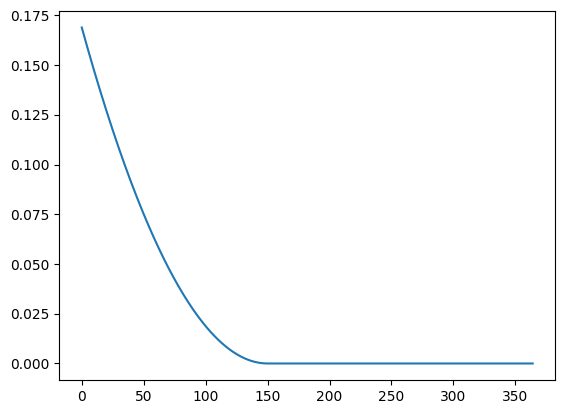

In [22]:
# Create dummy tensors
# t arange from 0 to T_dim
t = torch.arange(T_dim).unsqueeze(0).repeat(N, 1).float()
# mus is always 20
mu = 150.
mus = torch.ones(C)*mu
# z_t is zeros
z_t = torch.zeros(N, T_dim)
y_true = torch.randint(0, C, (N, T_dim))  # Random indices from 0 to C-1

# Calculate the output
output = lin_regr_zt(t, T_dim, mus, z_t, y_true)
print("Output Loss Tensor:", output)

# plot the output
plt.plot(output[0].detach().numpy())

The curve of the loss function is working as expected: it is decreasing over time, and get to 0 at mu. 

Train example

In [23]:
# ----------------------------- TRAINING -----------------------------
start_epoch = 1
print("starting training...")
with tqdm(range(start_epoch, config.epochs + 1)) as pbar:
    for epoch in pbar:
        trainloss = train_epoch(model, traindataloader, optimizer, criterion, device=config.device)
        testloss, stats = test_epoch(model, testdataloader, criterion, config.device, return_id=test_ds.return_id, daily_timestamps=config.daily_timestamps)
        break
    
        # plot timestamps left
        fig_timestamps, ax_timestamps = plt.subplots(figsize=(15, 7))
        plot_timestamps_left(stats, ax_timestamps, fig_timestamps)
        
        # statistic logging and visualization...
        precision, recall, fscore, support = sklearn.metrics.precision_recall_fscore_support(
            y_pred=stats["predictions_at_t_stop"][:, 0], y_true=stats["targets"][:, 0], average="macro",
            zero_division=0)
        accuracy = sklearn.metrics.accuracy_score(
            y_pred=stats["predictions_at_t_stop"][:, 0], y_true=stats["targets"][:, 0])
        kappa = sklearn.metrics.cohen_kappa_score(
            stats["predictions_at_t_stop"][:, 0], stats["targets"][:, 0])

        classification_loss = stats["classification_loss"].mean()
        earliness_reward = stats["earliness_reward"].mean()
        earliness = 1 - (stats["t_stop"].mean() / (config.sequencelength - 1))
        harmonic_mean = harmonic_mean_score(accuracy, stats["classification_earliness"])

starting training...


  0%|          | 0/100 [02:46<?, ?it/s]


In [24]:
#print the stats
precision, recall, fscore, support = sklearn.metrics.precision_recall_fscore_support(
    y_pred=stats["predictions_at_t_stop"][:, 0], y_true=stats["targets"][:, 0], average="macro",
    zero_division=0)
accuracy = sklearn.metrics.accuracy_score(
    y_pred=stats["predictions_at_t_stop"][:, 0], y_true=stats["targets"][:, 0])
kappa = sklearn.metrics.cohen_kappa_score(
    stats["predictions_at_t_stop"][:, 0], stats["targets"][:, 0])

classification_loss = stats["classification_loss"].mean()
# if stats contains "earliness_reward" key
if "earliness_reward" in stats:
    earliness_reward = stats["earliness_reward"].mean()
earliness = 1 - (stats["t_stop"].mean() / (config.sequencelength - 1))

print("Epoch: {} | Train Loss: {:.4f} | Test Loss: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f} | Accuracy: {:.4f} | Kappa: {:.4f} | Classification Loss: {:.4f} | Earliness: {:.4f} ".format(epoch, trainloss, testloss, precision, recall, fscore, accuracy, kappa, classification_loss, earliness))

Epoch: 1 | Train Loss: 13.8600 | Test Loss: 15.0961 | Precision: 0.0004 | Recall: 0.1429 | F1: 0.0008 | Accuracy: 0.0029 | Kappa: 0.0000 | Classification Loss: 16.7768 | Earliness: 0.0000 


In [25]:
stats["timestamps_left"].shape

(67523, 365)

(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Timestamps left'}, xlabel='day of year', ylabel='timestamps left'>)

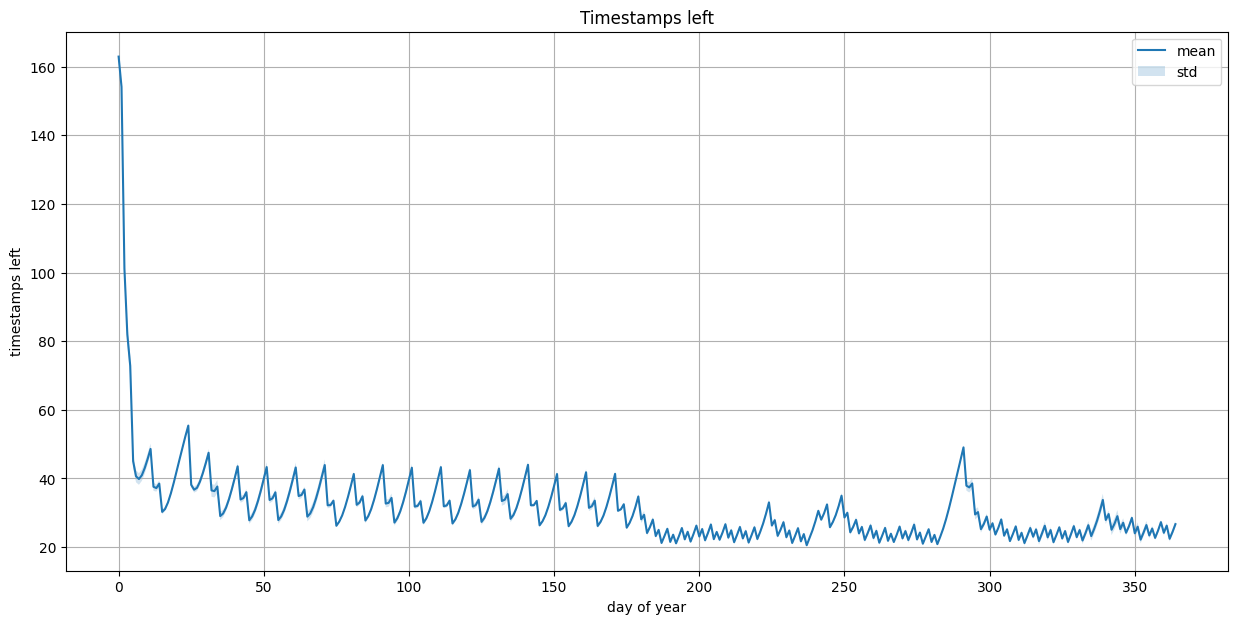

In [26]:
def plot_timestamps_left(stats, ax_timestamps, fig_timestamps):
    timestamps_left_mean = stats["timestamps_left"].mean(axis=0)
    timestamps_left_std = stats["timestamps_left"].std(axis=0)
    # plot mean and std
    ax_timestamps.plot(timestamps_left_mean, label="mean")
    ax_timestamps.fill_between(range(len(timestamps_left_mean)), timestamps_left_mean - timestamps_left_std,
                              timestamps_left_mean + timestamps_left_std, alpha=0.2, label="std")
    ax_timestamps.set_xlabel("day of year")
    ax_timestamps.set_ylabel("timestamps left")
    ax_timestamps.set_title("Timestamps left")
    ax_timestamps.legend()
    ax_timestamps.grid()
    
    return fig_timestamps, ax_timestamps


fig_timestamps, ax_timestamps = plt.subplots(figsize=(15, 7))
plot_timestamps_left(stats, ax_timestamps, fig_timestamps)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

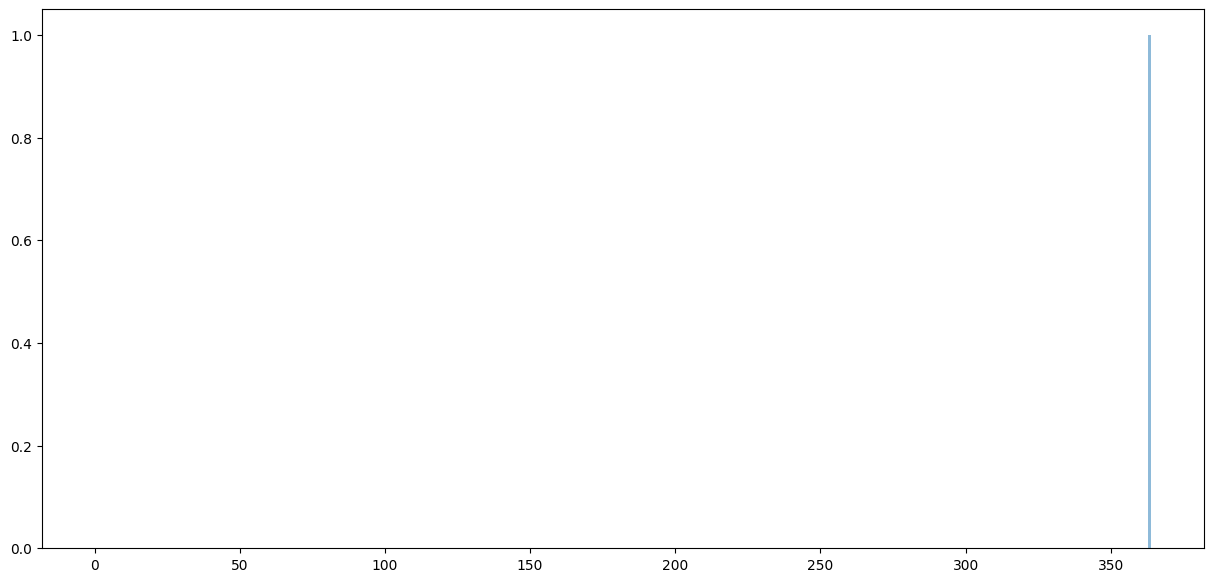

In [27]:
timestamps_left = stats["timestamps_left"]
# to torch tensor
timestamps_left = torch.from_numpy(timestamps_left)
t_stop = get_t_stop_from_daily_timestamps(timestamps_left, threshold=5)

# plot t_stop distribution
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(t_stop, bins=range(0, config.sequencelength), density=True, alpha=0.5, label="t_stop")

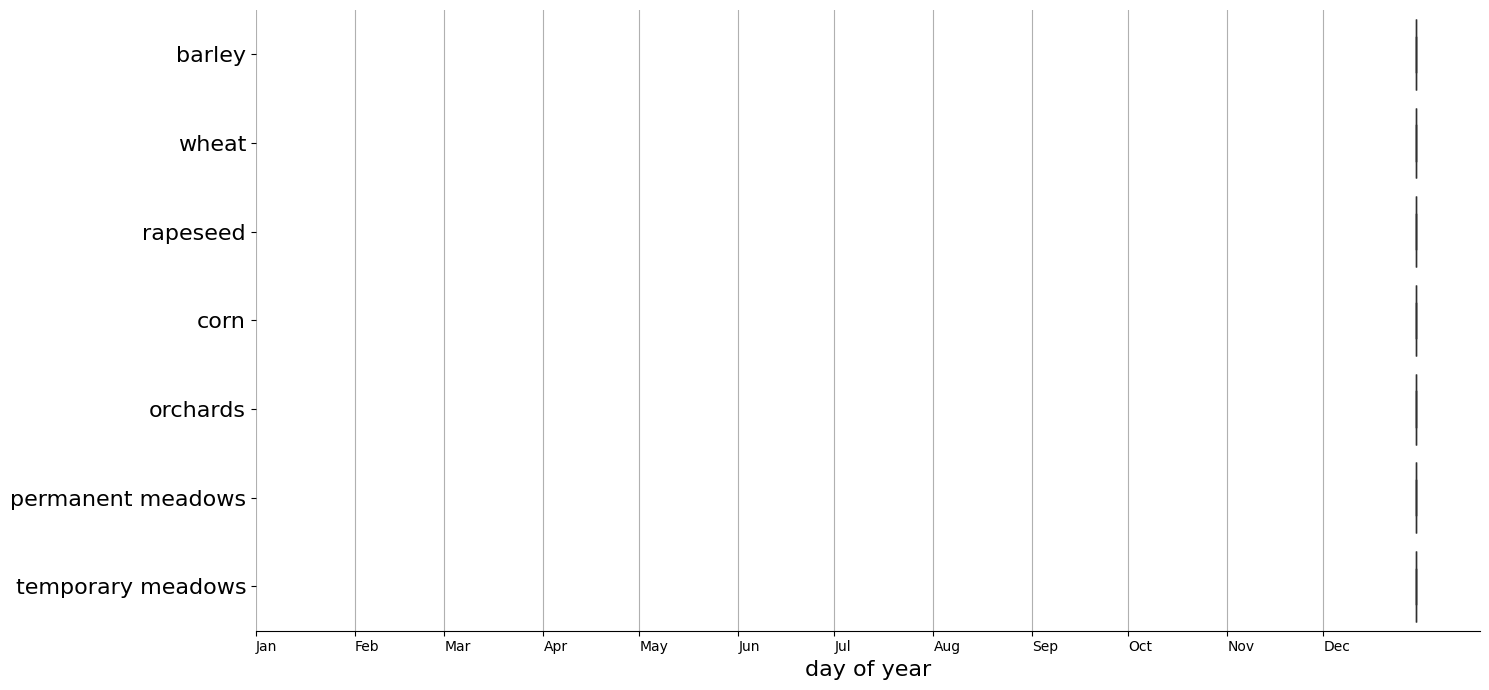

In [28]:
doys_stop = stats["t_stop"].squeeze()
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)

In [29]:
# dummy test for get_t_stop_from_daily_timestamps
# create daily_timestamps tensor, with only zeros 
batchsize = 10
daily_timestamps = torch.zeros((batchsize, config.sequencelength), dtype=torch.float)
print("daily_timestamps", daily_timestamps)
t_stop = get_t_stop_from_daily_timestamps(daily_timestamps, threshold=5)
print("t_stop", t_stop)


daily_timestamps tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
t_stop tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
